# Aineiston esikäsittely

Perustuu kirjan [Applied Predictive Modeling](http://appliedpredictivemodeling.com/) kolmanteen kappaleeseen Data Pre-processing.

Alkuperäiset esimerkit on toteutettu R-kielellä.

Materiaalina käytetään [solujen automatisoidun analysoinnin onnistumiseen vaikuttavien tekijöiden merkitystä selvittäneen tutkimuksen aineistoa](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-340).

Ladataan käytettävät paketit:

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import boxcox, kurtosis, skew, pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Määritetään suorituksen aikana käytettävät vakiot

In [2]:
BC_FIX = 0.1 # Sarakkeen pienimmän arvon itseisarvoon tehtävä lisäys
PORTION_OF_DISCRETE_VALUES = 0.1
RATIO_MOST_FREQUENT_OVER_SECOND_FREQUENT = 20

Luetaan käytettävä aineisto:

In [3]:
dataUrl = "https://raw.githubusercontent.com/RaimoHaikari/data-analytiikka/main/applied-predictive-modelling/data/segmentationOriginal.csv"
segmentationOriginal = pd.read_csv(dataUrl)
segmentationOriginal.head() 

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
0,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
1,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
2,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
3,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
4,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


Sarakkeista:

- *Cell* toimii yksilöivänä tietona
- *Class* on luokkamuuttuja, jonka avulla nähdään mitkä solut onnistuttiin luokittelemaan hyvin
- *Case* kertoo, kuuluiko näyte tutkimuksessa opetus- vai testijoukkoon

Kirjan esimerkki keskittyy opetusmateriaaliin, joten kopioidaan se omaan muuttujaansa.

Käytetään copy() -toimintoa, jotta yhteys alkuperäiseen aineistoon katkeaa.

In [4]:
ehto = segmentationOriginal['Case'] == 'Train'
segData = segmentationOriginal[ehto].copy(deep=True)

Mapataan Cell, Class ja Case omiin muuttujiinsa ja poistetaan ne kehikosta.

In [5]:
cellID = segData['Cell'].values
cellClass = segData['Class'].values
cellCase = segData['Case'].values

segData.drop(['Cell', 'Class', 'Case'], axis=1, inplace = True)

Aineisto sisältää useita sarakkeita, joiden nimessä on maininta: status. Näitä sarakkeita on käytetty ennusteiden manuaaliseen luokitteluun.

Poistetaan nämä sarakkeet:

In [6]:
# segData.columns.values
matching = [s for s in segData.columns.values if "Status" in s]
segData.drop(matching, axis=1, inplace = True)
segData.shape

(1009, 58)

## Muunnokset

Osalla muuttujista arvoissa esiintyy huomattavaa vinoutumista. 

Käydään sarakkeet läpi ja lasketaan kunkin muuttujan vinous. Arvoja voidaan käyttää esim. valittaessa muuttujia visuaalisen tarkastelun kohteeksi.

Huom. joillain muuttujilla antaa hieman kirjan esimerkistä poikkeavia arvoja, voi johtua esim. siitä, että ajan [skew-funktion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) oletusarvoilla.


- peukalosääntönä pidetään 0.75 raja-arvon ylittymistä, mikäli suurempi, vinoutta voidaan pitää merkittävänä


In [7]:

skewValues = segData.apply(skew, axis=0)
# skewValues.nlargest()
skewValues.nsmallest()

ConvexHullPerimRatioCh1   -1.306040
IntenCoocEntropyCh4       -1.162011
IntenCoocEntropyCh3       -1.077296
EntropyIntenCh3           -1.004446
EntropyIntenCh4           -0.829137
dtype: float64

### Box-Cox muunnos

Vinon aineiston oikaisuun käytettyjä menetelmiä ovat mm. logaritmin- , neliöjuuren - ja käänteisluvun laskeminen.

Muunnoksen jälkeen jakauma ei edelleenkään ole normaali, mutta 'käyttäytyy paremmin'.

Tilastotieteilijät Box ja Cox ovat esitelleen menetelmän, jonka avulla tarvittavan oikaisu voidaan matemaattisesti selvittää. Menetelmä perustuu havainnoista laskettavan tunnusluvun käyttöön.

Menetelmän käyttö edellyttää, että muuttujan arvot ovat nollaa suurempia. Yksi vaihtoehto negatiivisiä arvoja sisältävien sarakkeiden käsittelyyn on [vakioarvon lisääminen](https://stats.stackexchange.com/questions/399435/which-constant-to-add-when-applying-box-cox-transformation-to-negative-values). 

Selvitetään siltääkö aineisto *ei positiivisia* arvoja sisältäviä sarakkeita. Mikäli tällaisia sarakkeita löytyy, lisätään kuhunkin muuttujaan vakioarvo, joka on:

- pienimmän arvon itseisarvo plus 0.1 (BC_FIX)

Talletaan samalla muistiin käsitellyt sarakkeet ja suoritetut korjaukset.

In [8]:
def hasNegativeValues(x):
    return sum(x <= 0)

bcPreFixes = {}

nOfNegativeValues = segData.apply(lambda x: hasNegativeValues(x))

for (col,val) in nOfNegativeValues[nOfNegativeValues > 0].items():
    fix = abs(segData[col].min()) + BC_FIX

    bcPreFixes[col] = fix
    segData[col] += fix

Käytetään BoxCox muunnokseen scipy.stats paketista löytyvää [boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)-funktiota.

Funktio palauttaa tuple:n, jossa:

- ensimmäinen arvo sisältää muuttenut havainnot
- toinen arvo sisältää alkuperäisistä arvoista lasketun lambda-arvon.

Apply-funktio lapioi arvot kehikkoon (data.frame).

In [9]:
dfBoxCoxTF = segData.apply(lambda x: boxcox(x))

Kerätään esikäsitellyt havainnot omaan taulukkoonsa. Aloitetaan irroittamalla taulukon sisällöksi BoxCox-muunnetut havainnot.

In [10]:
preProcessed = segData.copy()

for col in dfBoxCoxTF.iloc[0,:].index:
    preProcessed[col] =  dfBoxCoxTF.iloc[0,:][col]

preProcessed.head()

,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,DiffIntenDensityCh1,DiffIntenDensityCh3,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1,57.903365,1.164652,2.079561,20.720858,7.626166,9.860604,0.152689,-0.116416,1.058970,5.011594,...,4.386359,337.699689,60.378343,63.367208,1.703092,5.212978,9.306629,1.685936,96.240610,34.411351
2,48.279721,1.161905,2.036514,15.632307,7.367308,8.500672,0.046967,-0.053760,1.059799,4.702854,...,4.273075,203.209204,49.378262,48.302136,1.677595,4.560954,6.672299,1.599054,150.772901,29.083580
3,34.013558,1.159491,1.905057,14.657995,5.250410,5.285649,0.131111,-0.092304,1.050595,3.967309,...,4.147955,165.026400,35.372697,31.789601,1.604898,4.212184,4.959997,1.481145,188.478514,31.602305
11,49.285617,1.158254,1.892483,16.326411,3.698258,6.253630,0.067659,-0.063555,1.052966,3.306213,...,4.113645,169.683470,27.413914,34.060211,1.607437,3.513057,6.135635,1.553733,94.761073,41.403421
14,47.415429,1.158321,1.865525,16.225962,4.734101,7.343587,0.063436,-0.056574,1.052712,3.426323,...,4.101993,169.370277,31.798520,38.115998,1.565167,3.442993,6.235527,1.555352,80.042449,26.201907


Tulostetaan suurimman ja pienimmän vinousarvon saaneiden muuttujien histogrammit ennen ja jälkeen boxcox-muunnoksen.

Määritetään aluksi aliohjelma, jonka avulla rinnakkaiset histogrammit saadaan tulostettua.

In [11]:
def printBCTransformationHistograms(name, value):

    kwargs = dict(histtype='stepfilled', alpha=1.0, bins=100, density = False)

    fig = plt.figure(constrained_layout=True, figsize=(6,4))
    spec = plt.GridSpec(ncols=2, nrows=1, figure=fig)

    ax1 = fig.add_subplot(spec[0, 0], xticklabels=[])
    ax2 = fig.add_subplot(spec[0, 1], xticklabels=[])


    ax1.hist(segData[name].values, **kwargs)
    ax1.set_title('Distribution before transformation')


    # ax2.hist(dfBoxCoxTF.iloc[0,:][name], **kwargs)
    ax2.hist(preProcessed[name].values, **kwargs)
    ax2.set_title('Distribution after transformation')


    fig.suptitle(f'{name} (skew: {value:.2f})')

Tulostetaan suurimma vinousarvon omanneen muuttujan havaintojen jakauma:

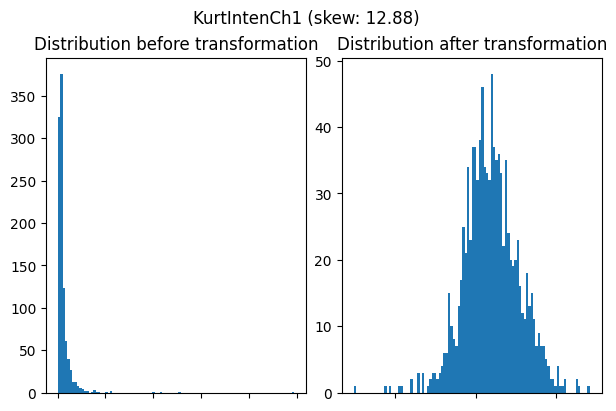

In [12]:
_name = list(skewValues.nlargest(1).index)[0]
_value = skewValues.nlargest(1).values[0]
printBCTransformationHistograms(_name, _value)

Tulostetaan pienintä vinousarvoa vastanneen muuttujan havaintojen jakauma:

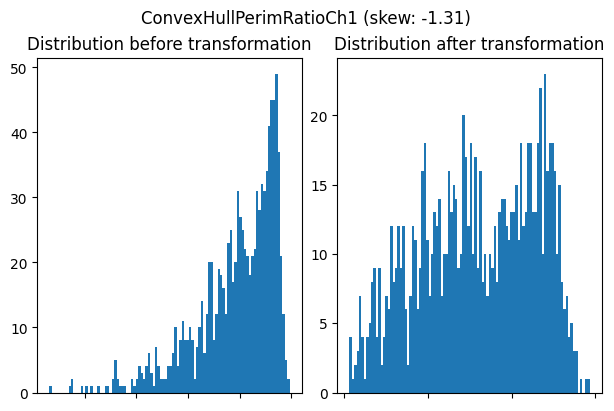

In [13]:
_name = list(skewValues.nsmallest(1).index)[0]
_value = skewValues.nsmallest(1).values[0]
printBCTransformationHistograms(_name, _value)

## Keskittäminen ja skaalaus

Englanniksi centering and scaling. Toimenpidettä kutsutaan myös [standardoimiseksi](https://www.youtube.com/watch?v=lfqjQeKwNmI).

Keskitettäessä havainnoista vähennetään havaintojen keskiarvo. Tästä seuraa, että havaintojen keskiarvo on operaation jälkeen 0.

Skaalatessa jokainen havainto jaetaan havaintojen keskihajonnalla. Tästä seuraa, että havaintojen keskihajonta on skaalauksen jälkeen 1.

Näin tehdään, koska tietyt laskelmat hyötyvät samaa suuruuusluokkaa olevista muuttujista, esim. data-analytiikkaan liittyvistä malleista oppaan kirjoittaja nostavat esille [PLS:n](https://en.wikipedia.org/wiki/Partial_least_squares_regression). 

Youtube-oppaassa [Python Machine Learning Tutorial | Centering And Scaling ](https://www.youtube.com/watch?v=lfqjQeKwNmI) toimenpiteestä hyötyvinä malleina nimetään:

- K-nearest neighbors
- Support vector machines (when using the 'kernel trick' of the radial basis function)
- Reqularized regression (lasso and ridge regression)

Seuraavien mallien toiminnan kannalta ei ole olennaista, mutta saataa helpottaa laskentaa (help with convergence):

- Linear and logistic regression
- Neural networks

Seuraavat mallit eivät hyödy millään lailla, joten standartointi on näiden kannalta hukkaan heitettyä aikaa:

- Tree-based models (decision trees, random forests, gradient boosting)
- Naive Bayes

Jatketaan esikäsittelyä standardoimalla arvot.

Standardointi kannattaa hoitaa kahdessa vaiheessa.

1. Määritetään malli opetusaineiston perusteella
2. Muunnetaan opetusaineisto juuri luodulla mallilla.

Kun malli on erikseen alustettu, voidaan sitä käyttää mahdollisen testiaineiston muuntamiseen.

StandardScaler palauttaa NumPy-taulukon. Stackoverflow:sta löytyi oiva [vinkki](https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num), kuinka havainnot saa helposti DataFrame:ksi.

In [14]:
std_scale = StandardScaler().fit(preProcessed)
# preProcessed = std_scale.transform(preProcessed)

preProcessed = pd.DataFrame(
    std_scale.transform(preProcessed),
    columns = preProcessed.columns,
    index= preProcessed.index
)

### Pääkomponenttianalyysi

Varsinkin kun kyse on laajoista aineistoista, aineistoa halutaan tiivistää. Tarkoituksena on tavoittaa aineiston olennaiset piirteet alkuperäisestä karsitulla muuttujamäärällä.

Pääkomponenttianalyysi on kierroksittain etenevä prosessi, joka projisoi aineiston keskenään kohtisuoriin yksiulotteisiinkomponentteihin, joista kukin valittu siten, että se selittää suurimman osan jäljellä olevasta selittämättömästä vaihtelusta.

Tiiivistämisen lisäksi PCA vähentää muuttujien välillä olevaa korrelaatiota. Jotkut mallit (predictive models) toimivat paremmin, kun muuttujien välillä on korkeintaan lievää korrelaatiota.

In [15]:
pca = PCA() # voi antaa halutun komponenttien määrän
pca.fit(preProcessed)

pca_data = pca.transform(preProcessed)

Ennen kuin jatketaan, tutustutaan hieman pääkomponenttianalyysin tuloksiin. Lähdetään liikkelle graafilla, joka kertoo paljonko kukin komponentti selittää aineiston käyttäytymisestä. Tulostetaan samaan graafiin myös selitetyn varianssin kumulatiivinen summa.

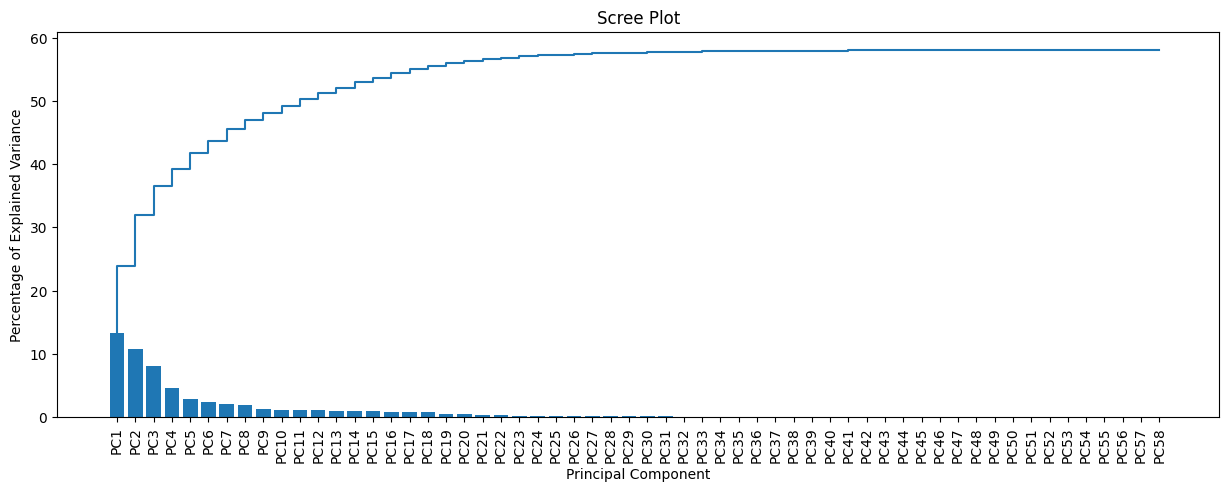

In [16]:
per_var = np.round(pca.explained_variance_ , decimals= 1)
cum_sum = np.cumsum(pca.explained_variance_)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

fig = plt.figure(figsize=(15,5))
ax = plt.axes()

ax.bar(
    x = range(1, len(per_var) + 1),
    height = per_var,
    tick_label = labels
)

ax.step(
    range(1, len(per_var) + 1), 
    cum_sum
)

plt.xticks(rotation=90)


plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Component")
plt.title("Scree Plot")
plt.show()

Graafin tarkastelu osoittaa, että jotain on selkeästi vialla: kaikkien komponenttien kumulatiivinen summa pitäisi olla 100.

Jostain syystä tämä ei kuitenkaan toteudu. Tämän työkirjan tarkoitus on käydä läpi alkuperäisessä oppaassa suoritetut toimenpiteet, joten edetään tässä vaiheessa seuraavaan toimenpiteeseen ja yrittään selvittää PCA:n epäonnistumista paremmalla ajalla.

Jätetään pääkomponenttianalyysin tulokset käyttämättä, eli jatketaan tästä eteenpäin aineistolla, jolle on suoritettu BoxCox-muunnos, jonka jälkeen aineisto on standardoitu.

## Muuttujien karsiminen

### Vähän informaatiota sisältävät muuttujat

Kirjassa käytettään termiä Near Zero variables muuttujista, jotka:

- sisältävät vain muutamia diskreettejä arvoja
- melkein kaikki havainnot edustavat samaa arvoa

Tällaiset muuttujat eivät tuo malliin juuri tietoa, mutta saattavat sotkea mallin toimintaa. LJaettaessa aineistoja opetus- ja testijoukkoihin saatetaan joutua vaikeuksiin, kun jonkun arvon edustajia ei riitä näytteeseen.

Sinänsä diskreettien arvojen vähäisyys ei ole onglema, ns. 'dummy-muuttujat' ovat luonteeltaan tällaisia.

Kirja ehdottaa, että muuttuja poistetaan kun molemmat seuraavista ehdoista toteutuu:

- diskreettien muuttujien lukumäärän suhte havaintoihin on pieni, esim. alle 10%
- yleisimmän arvon esiintymiskertojen määrä verrattuna seuraavaksi yleisimmän arvon esiintymiskertohin on moninkertainen, esim. 20-kertainen.

Määritetään aliohjelma, joka avulla voidaan käydä muuttujat läpi ja testata missä määrin em. ehdot toteutuvat.

(Ilmeisesti) vastaava toimenpide voidaan toteuttaa sklearn paketti sisältää [VarianceThreshold-funktion](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) avulla. 

Tässä aineistossa vähäisen varianssin muuttujia ei ole.

In [17]:
def isNearZeroVariable(x):
    _nOfItems = x.shape[0]  # 13
    _valueCounts = x.value_counts()
    _nOfDiscreteValues = _valueCounts.shape[0]

    if _nOfDiscreteValues == 1:
        return True

    # Diskreettien muuttujien määrä suhteessa havaintojen määrään
    _discreteRatio = _nOfDiscreteValues / _nOfItems

    # Yleisimmän arvon esiintymiskerrat verrattuna toiseksi yleisimpään
    _freqRatio = _valueCounts.values[0] / _valueCounts.values[1]

    if _discreteRatio < PORTION_OF_DISCRETE_VALUES and _freqRatio > RATIO_MOST_FREQUENT_OVER_SECOND_FREQUENT:
        return True

    return False

#preProcessed = pd.DataFrame(
#    pca_data,
#    columns = labels,
#    index= preProcessed.index
#)

nzVariables = preProcessed.apply(lambda x: isNearZeroVariable(x))
print(f'Vähäisen varianssin muuttujia on yhteenä {sum(nzVariables)} kappaletta')

Vähäisen varianssin muuttujia on yhteenä 0 kappaletta


### Voimakkaasti korreloivat muuttujat

Matriisin tarkastelu on melkoisen hankalaa. 

In [18]:
corr_mat = preProcessed.corr().round(2)
corr_mat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(6)

C:\Users\raimo\AppData\Local\Temp\ipykernel_4244\737806609.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(6)


,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,DiffIntenDensityCh1,DiffIntenDensityCh3,DiffIntenDensityCh4,EntropyIntenCh1,EntropyIntenCh3,EntropyIntenCh4,EqCircDiamCh1,EqEllipseLWRCh1,EqEllipseOblateVolCh1,EqEllipseProlateVolCh1,EqSphereAreaCh1,EqSphereVolCh1,FiberAlign2Ch3,FiberAlign2Ch4,FiberLengthCh1,FiberWidthCh1,IntenCoocASMCh3,IntenCoocASMCh4,IntenCoocContrastCh3,IntenCoocContrastCh4,IntenCoocEntropyCh3,IntenCoocEntropyCh4,IntenCoocMaxCh3,IntenCoocMaxCh4,KurtIntenCh1,KurtIntenCh3,KurtIntenCh4,LengthCh1,NeighborAvgDistCh1,NeighborMinDistCh1,NeighborVarDistCh1,PerimCh1,ShapeBFRCh1,ShapeLWRCh1,ShapeP2ACh1,SkewIntenCh1,SkewIntenCh3,SkewIntenCh4,SpotFiberCountCh3,SpotFiberCountCh4,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
AngleCh1,1.000000,0.000000,-0.030000,-0.020000,-0.040000,-0.030000,-0.040000,0.040000,-0.060000,-0.050000,-0.040000,-0.020000,-0.020000,0.010000,0.000000,0.050000,0.020000,-0.020000,0.000000,0.000000,0.010000,0.040000,-0.000000,0.010000,0.010000,-0.020000,0.010000,-0.000000,-0.010000,0.010000,0.010000,-0.010000,-0.060000,-0.020000,-0.020000,0.030000,0.010000,0.040000,-0.020000,0.000000,0.050000,0.060000,-0.010000,-0.040000,-0.020000,-0.010000,0.050000,0.030000,-0.030000,-0.010000,-0.030000,-0.020000,-0.050000,-0.040000,-0.040000,-0.060000,-0.050000,-0.060000
AreaCh1,0.000000,1.000000,-0.060000,-0.000000,-0.100000,0.060000,0.290000,-0.430000,-0.080000,-0.110000,0.050000,0.210000,0.070000,0.230000,1.000000,0.080000,0.950000,0.940000,1.000000,1.000000,-0.130000,-0.120000,0.670000,0.300000,0.110000,0.020000,-0.080000,-0.050000,0.020000,0.110000,0.150000,0.040000,0.110000,0.160000,0.030000,0.780000,0.030000,0.280000,-0.040000,0.830000,-0.220000,0.070000,0.340000,0.140000,0.140000,0.060000,0.470000,0.660000,0.410000,0.380000,0.350000,0.420000,-0.010000,-0.040000,0.100000,0.770000,-0.020000,-0.140000
AvgIntenCh1,-0.030000,-0.060000,1.000000,0.570000,0.420000,0.450000,-0.450000,0.520000,0.960000,0.390000,0.440000,0.930000,-0.020000,0.340000,-0.060000,-0.270000,-0.140000,0.020000,-0.060000,-0.060000,-0.110000,-0.030000,-0.420000,0.440000,0.220000,-0.220000,-0.350000,0.050000,-0.240000,0.210000,0.210000,-0.240000,-0.350000,0.090000,-0.140000,-0.270000,-0.060000,-0.100000,-0.070000,-0.320000,0.370000,-0.230000,-0.490000,-0.390000,0.120000,-0.200000,-0.070000,-0.220000,0.870000,0.500000,0.350000,0.380000,0.960000,0.510000,0.440000,-0.050000,-0.090000,-0.090000
AvgIntenCh2,-0.020000,-0.000000,0.570000,1.000000,0.070000,0.620000,-0.570000,0.460000,0.500000,0.040000,0.610000,0.500000,-0.240000,0.480000,-0.000000,-0.450000,-0.150000,0.150000,-0.000000,-0.000000,-0.140000,0.010000,-0.470000,0.580000,0.420000,-0.260000,-0.470000,0.070000,-0.400000,0.280000,0.440000,-0.280000,-0.290000,0.120000,-0.280000,-0.350000,-0.060000,-0.090000,-0.060000,-0.360000,0.440000,-0.390000,-0.590000,-0.390000,0.170000,-0.310000,-0.070000,-0.200000,0.520000,0.900000,0.050000,0.550000,0.500000,0.190000,0.620000,0.080000,-0.040000,-0.060000
AvgIntenCh3,-0.040000,-0.100000,0.420000,0.070000,1.000000,0.390000,0.080000,0.010000,0.490000,0.970000,0.420000,0.380000,0.700000,0.290000,-0.100000,-0.050000,-0.110000,-0.100000,-0.100000,-0.100000,0.020000,0.080000,-0.060000,-0.090000,-0.430000,-0.250000,0.200000,0.120000,0.430000,0.230000,-0.440000,-0.240000,0.170000,-0.300000,-0.070000,-0.090000,-0.070000,0.030000,-0.050000,-0.060000,-0.040000,-0.080000,0.000000,0.130000,-0.330000,-0.150000,-0.100000,-0.260000,0.330000,0.030000,0.880000,0.320000,0.480000,0.920000,0.390000,-0.040000,0.020000,0.010000
AvgIntenCh4,-0.030000,0.060000,0.450000,0.620000,0.390000,1.000000,-0.310000,0.260000,0.400000,0.330000,0.980000,0.420000,0.240000,0.840000,0.060000,-0.360000,-0.060000,0.180000,0.060000,0.060000,-0.070000,0.040000,-0.280000,0.390000,-0.020000,-0.590000,-0.150000,0.240000,0.050000,0.600000,0.000000,-0.590000,-0.140000

Matriisin tarkastelu on melkoisen hankalaa. Tulostetaan arvoista lämpökartta.

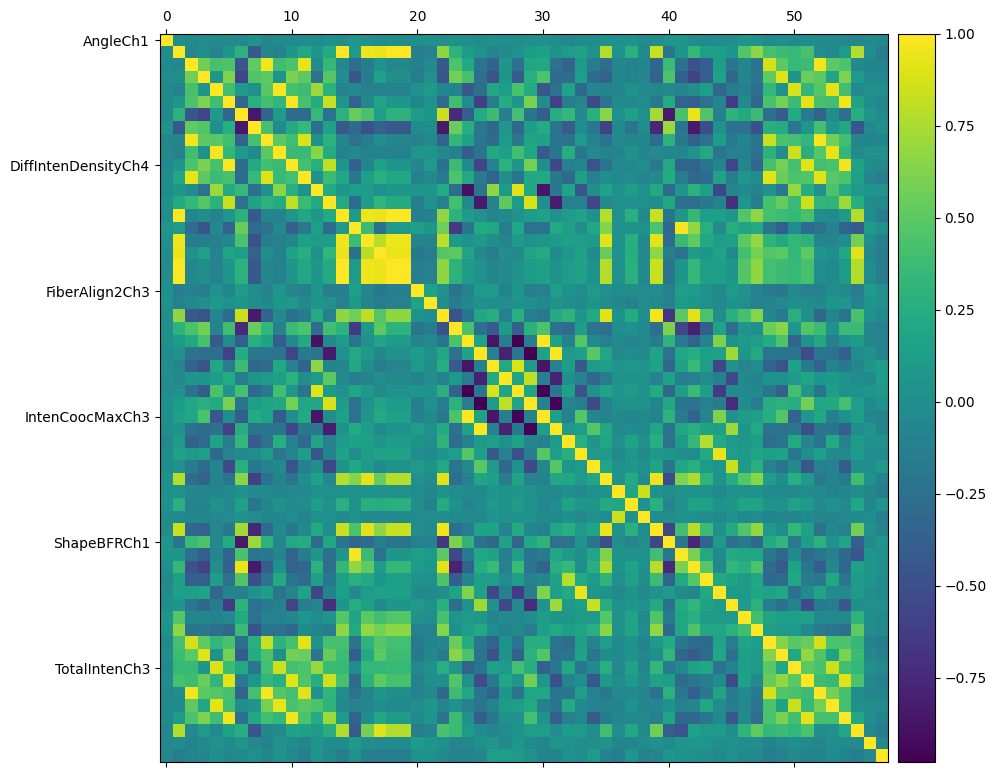

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

ax.yaxis.set_ticks(np.arange(0,preProcessed.shape[1]))
ax.set_yticklabels(preProcessed.columns)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)


im = ax.matshow(corr_mat)
fig.colorbar(im, cax=cax, orientation='vertical')

Tavoite poistamaa mahdollisimman vähän muuttujia siten, että jäljelle jäävien muuttujien väliset korrelaatiokertoimet eivät ylitä rajaaa

1. Lasketaan korrelaatiomatriisi
2. Etsitään voimakkaimmin korreloiva muuttujapari

[apua](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas)
[lisäApu](https://stackoverflow.com/questions/44152154/drop-a-row-and-column-at-the-same-time-pandas-dataframe)

EqCircDiamCh1    EqSphereVolCh1     1.0

In [10]:
def _findCorrelation(correlations, limit = 0.75):

    removed = set()

    _tril = correlations.copy()
    _tril.loc[:,:] = np.tril(_tril.values, k=-1)

    s = _tril.stack()
    so = s.sort_values(ascending = False, kind="quicksort")


    for preds in so.index:

        predA = preds[0]
        predB = preds[1]

        # Jos ollaan päästy rajan alle, voidaan lopettaa
        if so[preds] < limit:
            break

        # Onko jompikumpi muuttujista jo poisttavien listalla
        if predA in removed or predB in removed:
            continue

        # Keskimääräinen korrelaattio muuttujan A ja muiden muuttujien välillä
        _corrA = correlations[predA].mean()
        # Keskimääräinen korrelaattio muuttujan B ja muiden muuttujien välillä
        _corrB = correlations[predB].mean()

        if _corrA > _corrB:
            removed.add(predA)
        else:
            removed.add(predB)

    return removed



#_removed = findCorrelation(corr_mat)

# print(len(_removed))
        